In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense

from sklearn.preprocessing import MaxAbsScaler

# To remove the scientific notation from numpy arrays
np.set_printoptions(suppress=True)

In [2]:


# Load the dataset file
dataset = pd.read_pickle('SNR_BBH-injections-reduced-1m.pkl')

dataset = dataset.loc[dataset["SNR"] <= 100]

TargetVariable = ['SNR']
Predictors = ['Mc', 'q', 'inc', 'ra' , 'dec' , 'spin1_mag', 'spin1_polar', 'spin1_azimuthal', 'spin2_mag', 'spin2_polar', 'spin2_azimuthal']


X = dataset[Predictors].values
y = dataset[TargetVariable].values


# Sandardization of data #
PredictorScaler = StandardScaler()
Xscaled = PredictorScaler.fit_transform(X)


TargetScaler =  StandardScaler()
yscaled = TargetScaler.fit_transform(y)


# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xscaled, yscaled, test_size=0.3, random_state=42)
 

In [3]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (699997, 11)
y_train shape: (699997, 1)


In [14]:
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, AveragePooling1D, Flatten, Dense , GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import PReLU
from keras.optimizers import Nadam


def convolutional_block(x, filters, kernel_size, strides=1):
    shortcut = x

    # First Conv1D layer
    x = Conv1D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = PReLU()(x)

    # Second Conv1D layer
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # Adjust the shortcut to match the shape of x
    shortcut = Conv1D(filters, kernel_size=1, strides=strides, padding='same')(shortcut)
    shortcut = BatchNormalization()(shortcut)

    # Add shortcut to the output
    x = Add()([x, shortcut])
    x = PReLU()(x)

    return x

def identity_block(x, filters, kernel_size):
    shortcut = x

    # First Conv1D layer
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = PReLU()(x)

    # Second Conv1D layer
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # Add shortcut to the output
    x = Add()([x, shortcut])
    x = PReLU()(x)

    return x

# Input layer
input_shape = (11, 1)  # Adjust the input shape 
input_tensor = Input(shape=input_shape)



# Initial Conv1D layer with PReLU activation
x = Conv1D(64, 7, strides=2, padding='same')(input_tensor)
x = BatchNormalization()(x)
x = PReLU()(x)



# Residual Blocks
x = convolutional_block(x, filters=64, kernel_size=7)
x = identity_block(x, filters=64, kernel_size=7)
x = identity_block(x, filters=64, kernel_size=7)
x = identity_block(x, filters=64, kernel_size=7)
x = identity_block(x, filters=64, kernel_size=7)




x = convolutional_block(x, filters=128, kernel_size=5)
x = identity_block(x, filters=128, kernel_size=5)
x = identity_block(x, filters=128, kernel_size=5)
x = identity_block(x, filters=128, kernel_size=5)
x = identity_block(x, filters=128, kernel_size=5)
x = identity_block(x, filters=128, kernel_size=5)





x = convolutional_block(x, filters=256, kernel_size=3)
x = identity_block(x, filters=256, kernel_size=3)
x = identity_block(x, filters=256, kernel_size=3)
x = identity_block(x, filters=256, kernel_size=3)
x = identity_block(x, filters=256, kernel_size=3)
x = identity_block(x, filters=256, kernel_size=3)



x = convolutional_block(x, filters=512, kernel_size=3)
x = identity_block(x, filters=512, kernel_size=3)
x = identity_block(x, filters=512, kernel_size=3)




x = convolutional_block(x, filters=256, kernel_size=2)
x = identity_block(x, filters=256, kernel_size=2)
x = identity_block(x, filters=256, kernel_size=2)
x = identity_block(x, filters=256, kernel_size=2)
x = identity_block(x, filters=256, kernel_size=2)
x = identity_block(x, filters=256, kernel_size=2)


x = convolutional_block(x, filters=512, kernel_size=1)
x = identity_block(x, filters=512, kernel_size=1)
x = identity_block(x, filters=512, kernel_size=1)
x = identity_block(x, filters=512, kernel_size=1)



# Average pooling and fully connected layers
x = GlobalAveragePooling1D()(x)
x = Dense(1, activation='linear')(x)  

# Create the model
model = Model(inputs=input_tensor, outputs=x)

custom_optimizer = Nadam(learning_rate=0.001)

# Compile the model with an appropriate loss and optimizer 
model.compile(loss='mse', optimizer=custom_optimizer)

# Define the number of epochs and batch size
batch_size = 400
epochs = 100

# Train the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))


Epoch 1/100
1750/1750 [==============================] - 165s 84ms/step - loss: 0.3981 - val_loss: 0.1120
Epoch 2/100
1750/1750 [==============================] - 145s 83ms/step - loss: 0.0928 - val_loss: 0.0915
Epoch 3/100
1750/1750 [==============================] - 147s 84ms/step - loss: 0.0676 - val_loss: 0.0764
Epoch 4/100
1750/1750 [==============================] - 146s 83ms/step - loss: 0.0577 - val_loss: 0.1117
Epoch 5/100
1750/1750 [==============================] - 147s 84ms/step - loss: 0.0517 - val_loss: 0.1681
Epoch 6/100
1750/1750 [==============================] - 147s 84ms/step - loss: 0.0452 - val_loss: 0.0770
Epoch 7/100
1750/1750 [==============================] - 145s 83ms/step - loss: 0.0396 - val_loss: 0.0747
Epoch 8/100
1750/1750 [==============================] - 142s 81ms/step - loss: 0.0338 - val_loss: 0.0515
Epoch 9/100
1750/1750 [==============================] - 141s 80ms/step - loss: 0.0292 - val_loss: 0.0379
Epoch 10/100
1750/1750 [======================

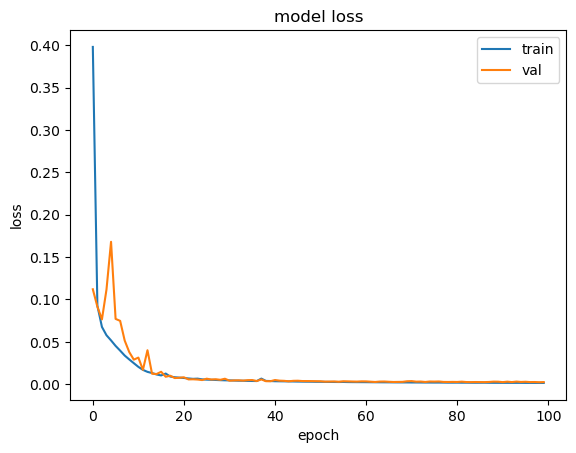

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.savefig("Figure_loss.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [16]:
# Generating Predictions on testing data
Predictions_scaled = model.predict(X_test)

# Scaling the test data back to original scale
Test_Data = PredictorScaler.inverse_transform(X_test)

# Scaling the y_test Price data back to original price scale
y_test_orig=TargetScaler.inverse_transform(y_test)

# Scaling the predicted Price data back to original price scale
Predictions = TargetScaler.inverse_transform(Predictions_scaled)

# Create table with test data and predictions
TestingData = pd.DataFrame( data = Test_Data, columns = Predictors)
TestingData['SNR'] = y_test_orig
TestingData['PredictedSNR'] = Predictions

# Computing the absolute percent error
APE = 100*(abs( (TestingData['SNR']-TestingData['PredictedSNR'])/TestingData['SNR']) )
TestingData['APE']=APE

# Computing the error
Error = TestingData['SNR']-TestingData['PredictedSNR']
TestingData['Error']=Error


TestingData.head()

9375/9375 [==============================] - 152s 16ms/step


,Mc,q,inc,ra,dec,spin1_mag,spin1_polar,spin1_azimuthal,spin2_mag,spin2_polar,spin2_azimuthal,SNR,PredictedSNR,APE,Error
0,13.629561,5.024858,0.759582,1.157298,0.546656,0.814804,0.191502,5.077727,0.877996,0.110203,5.707897,13.988222,14.298923,2.221156,-0.310700
1,13.506763,1.873409,0.496980,2.336597,0.743398,0.444129,1.696529,5.894138,0.480214,1.640247,3.345891,14.263174,14.075691,1.314452,0.187483
2,16.706566,1.790420,2.224368,1.441924,0.536652,0.038654,1.737126,4.311931,0.670894,0.304500,0.771137,15.918194,15.895711,0.141239,0.022483
3,31.103646,1.020864,2.009380,3.259870,0.432807,0.269319,0.198721,4.969034,0.881395,1.221976,3.256650,8.188298,8.175990,0.150307,0.012308
4,22.591072,3.238326,1.340895,5.087919,-0.129831,0.563057,1.479941,3.217394,0.154200,2.685003,2.336052,6.937942,7.196320,3.724125,-0.258378


In [17]:
# Compute MAPE and accuracy

MAPE = np.mean(TestingData['APE'])
accuracy = 100 - MAPE

print('MAPE:', MAPE, 'accuracy:', accuracy)

MAPE: 2.907582158304501 accuracy: 97.0924178416955


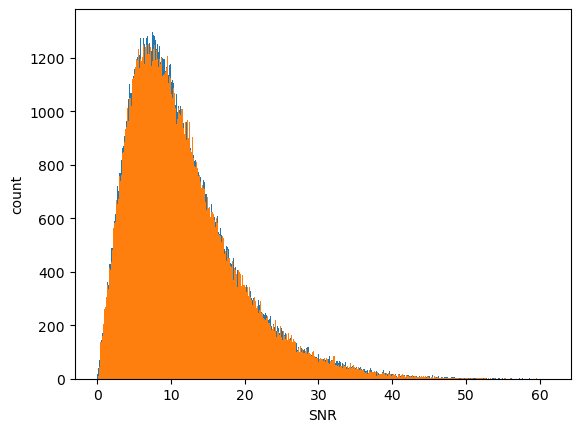

In [18]:
count, bins, ignored = plt.hist(y_test_orig, 1000)
count, bins, ignored = plt.hist(Predictions, 1000)
plt.xlabel('SNR')
plt.ylabel('count')

plt.savefig("Figure_SNR.pdf", format="pdf", bbox_inches="tight")
plt.show()

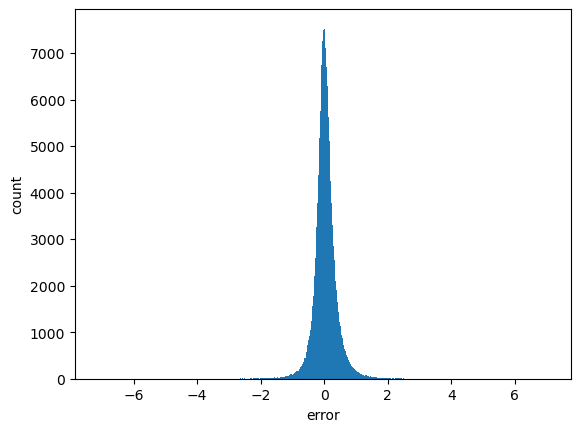

In [19]:
count, bins, ignored = plt.hist(TestingData['Error'], 1000)
#plt.xlim(-100,100)
plt.xlabel('error')
plt.ylabel('count')

plt.savefig("Figure_error.pdf", format="pdf", bbox_inches="tight")
plt.show()

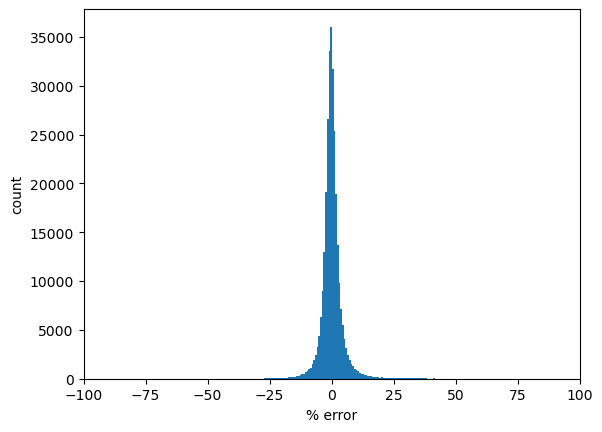

In [20]:
rel_error = 100*(Predictions - y_test_orig)/y_test_orig

count, bins, ignored = plt.hist(rel_error, 2000)
plt.xlabel('% error')
plt.ylabel('count')
plt.xlim(-100,100)

plt.show()

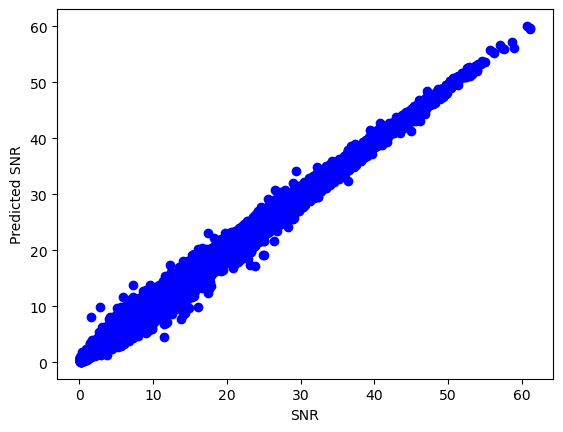

In [21]:
plt.plot(y_test_orig, Predictions, 'bo')
#plt.ylabel('loss')
#plt.xlabel('epoch')
#plt.legend(['train', 'val'], loc='upper right')
plt.xlabel('SNR')
plt.ylabel('Predicted SNR')

plt.savefig("Figure_predicted.pdf", format="pdf", bbox_inches="tight")
plt.show()

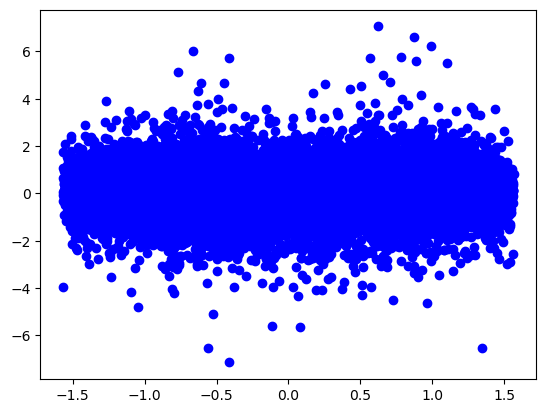

In [22]:
plt.plot(TestingData['dec'], TestingData['Error'], 'bo')
#plt.ylabel('loss')
#plt.xlabel('epoch')
#plt.legend(['train', 'val'], loc='upper right')
plt.show()

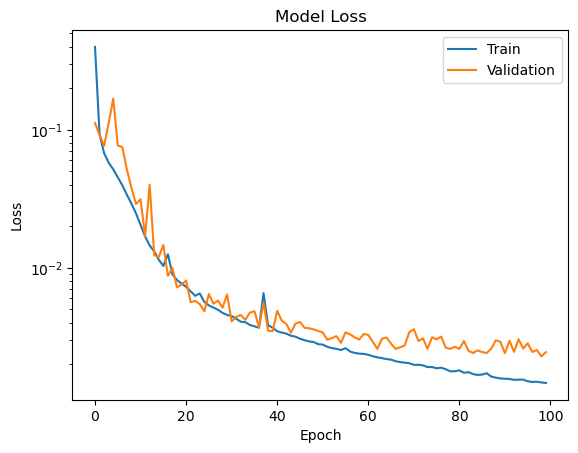

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Set the y-axis to a logarithmic scale for better visualization
plt.yscale('log')

# Save the figure with tight layout
plt.savefig("Figure_loss_zoomed.pdf", format="pdf", bbox_inches="tight")

# Show the plot
plt.show()
